In [1]:
#import libraries
%matplotlib inline
import os.path
import pandas as pd
import numpy as np
import tensorflow as tf
import keras_tuner as kt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import itertools
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

In [2]:
# Read in the Xtrain, Xtest, ytrain, ytest datasets
Xtrain = pd.read_csv('Resources/X_train_SMOTEENN_balanced_unscaled_train_dataset.csv')
Xtest = pd.read_csv('Resources/X_test_SMOTEENN_balanced_unscaled_train_dataset.csv')
ytrain = pd.read_csv('Resources/y_train_SMOTEENN_balanced_unscaled_train_dataset.csv')
ytest = pd.read_csv('Resources/y_test_SMOTEENN_balanced_unscaled_train_dataset.csv')

In [3]:
Xtrain.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status
0,0,64.0,1,0,1,3,1,93.78,24.4,2
1,0,32.0,0,0,1,2,1,104.92,22.6,2
2,0,5.0,0,0,0,4,0,59.61,17.1,0
3,1,70.0,0,0,1,2,1,64.41,29.4,3
4,1,44.0,0,0,1,2,1,99.34,33.1,2


In [4]:
X_train=Xtrain.drop(columns=['ever_married','work_type','Residence_type'])
X_test=Xtest.drop(columns=['ever_married','work_type','Residence_type'])
X_test.head()

,gender,age,hypertension,heart_disease,avg_glucose_level,bmi,smoking_status
0,1,72.0,1,0,114.01,31.8,1
1,0,44.0,0,0,68.42,43.2,3
2,0,35.0,0,0,89.11,24.4,2
3,1,26.0,0,0,190.67,20.2,2
4,1,68.0,0,0,116.23,26.1,2


In [5]:
#Create our model for the tuner
def create_model(hp):
    nn_model = tf.keras.models.Sequential()

    # Allow kerastuner to decide which activation function to use in hidden layers
    activation = hp.Choice('activation',['relu','tanh','sigmoid'])
    
    # Allow kerastuner to decide number of neurons in first layer
    nn_model.add(tf.keras.layers.Dense(units=hp.Int('first_units',
        min_value=1,
        max_value=10,
        step=2), activation=activation, input_dim=7))

    # Allow kerastuner to decide number of hidden layers and neurons in hidden layers
    for i in range(hp.Int('num_layers', 1, 6)):
        nn_model.add(tf.keras.layers.Dense(units=hp.Int('units_' + str(i),
            min_value=1,
            max_value=10,
            step=2),
            activation=activation))
    
    nn_model.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

    # Compile the model
    nn_model.compile(loss="binary_crossentropy", optimizer='adam', metrics=["accuracy"])
    
    return nn_model

In [6]:
# create the tuner
med_tuner = kt.Hyperband(
    create_model,
    objective="val_accuracy",
    overwrite=True,
    max_epochs = 50,
    directory = 'Tuners',
    project_name = 'med_SMOOTEEN_unscaled',
    hyperband_iterations=2,)

In [7]:
# Run the kerastuner search for best hyperparameters
med_tuner.search(X_train, ytrain ,epochs=20,validation_data=(X_test, ytest))

Trial 180 Complete [00h 00m 08s]
val_accuracy: 0.95652174949646

Best val_accuracy So Far: 0.95652174949646
Total elapsed time: 00h 06m 51s
INFO:tensorflow:Oracle triggered exit


In [8]:
# Get best model hyperparameters
best_hyper = med_tuner.get_best_hyperparameters(1)[0]
best_hyper.values

{'activation': 'tanh',
 'first_units': 7,
 'num_layers': 3,
 'units_0': 3,
 'tuner/epochs': 2,
 'tuner/initial_epoch': 0,
 'tuner/bracket': 3,
 'tuner/round': 0,
 'units_1': 1,
 'units_2': 1}

In [9]:
# Evaluate best model against full test data
best_model = med_tuner.get_best_models(1)[0]
model_loss, model_accuracy = best_model.evaluate(X_test, ytest, verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

31/31 - 0s - loss: 0.3871 - accuracy: 0.9565
Loss: 0.38711655139923096, Accuracy: 0.95652174949646


In [10]:
#get prediction of y from the best model
predictions = best_model.predict(X_test)

#round predictions for use in confusion matrix
rounded_pred = np.argmax(predictions, axis=1)


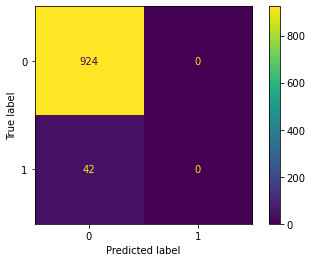

In [11]:
#print confusion matrix
cm = confusion_matrix(ytest, rounded_pred)

cm_display = ConfusionMatrixDisplay(cm).plot()
    

In [12]:
print(classification_report(ytest, rounded_pred))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98       924
           1       0.00      0.00      0.00        42

    accuracy                           0.96       966
   macro avg       0.48      0.50      0.49       966
weighted avg       0.91      0.96      0.94       966



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [13]:
if os.path.isfile('Models/Med_SMOOTEEN_unscaled.h5') is False:
    best_model.save('Models/Med_SMOOTEEN_unscaled.h5')